implementação do swin transforme para processamento de imagens pode ser interessante aplicar quando temos altas resoluçoes nesse caso poderiamos citar um uso para esse tipo de transforms

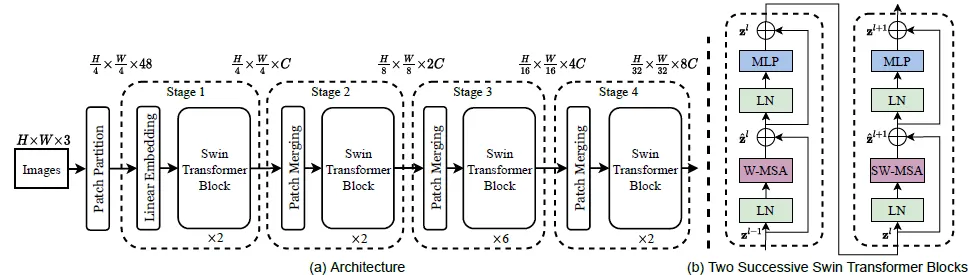

In [1]:
!pip install transformers datasets torch torchvision

In [2]:
from transformers import AutoImageProcessor, SwinForImageClassification
import torch
from google.colab import files
import os
import shutil
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import cuda
from torch.amp import autocast, GradScaler
import torch.multiprocessing as mp
import concurrent.futures
import timm

In [3]:
uploaded = files.upload()

Saving archive.zip to archive.zip


# arquivo e path

In [3]:
import zipfile
import os

caminho_zip = "/content/archive.zip"
with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")

os.listdir("dataset")


['Testing_set.csv', 'train', 'Training_set.csv', 'test']

In [4]:
import os, csv, shutil

CSV = "/content/dataset/Training_set.csv"
SRC = "/content/dataset/train"        # onde estão as imagens originais
DST = "/content/butterfly"    # destino organizado por classe

os.makedirs(DST, exist_ok=True)

with open(CSV, newline='', encoding="utf-8") as f:
    r = csv.DictReader(f)
    for row in r:
        fname = row['filename'].strip()
        label = row['label'].strip()
        src_path = os.path.join(SRC, fname)
        if not os.path.isfile(src_path):
            print("Faltando:", fname)
            continue
        class_dir = os.path.join(DST, label)
        os.makedirs(class_dir, exist_ok=True)
        dest_path = os.path.join(class_dir, fname)
        if os.path.exists(dest_path):
            base, ext = os.path.splitext(fname)
            k = 1
            while True:
                alt = f"{base}_{k}{ext}"
                dest_path = os.path.join(class_dir, alt)
                if not os.path.exists(dest_path):
                    break
                k += 1
        shutil.move(src_path, dest_path)   # trocar por shutil.copy2 se quiser copiar
print("Pronto.")

Pronto.


## converte de rgba para rgb

In [5]:
def custom_loader(path):
    # Open the image
    img = Image.open(path)
    # Ensure the image is in RGB mode even if RGBA
    img = img.convert('RGBA')
    return img.convert('RGB')

## normalização das imagens

padronizar o tamanho, contraste, saturação, brilho

nesse caso vamos normalizar o tamanho e vamos aplicar um espaço para um padrao de normalização assim evitamos ruido, aplicando tensores para operação de calculo pela gpu e gerando maior performace

## backup do modelo caso tenhamos um backup ou checkpoint (evita de salvar toda hora e de refazer os calculos)

In [ ]:
import torch, json, timm

CHECKPOINT = "/content/swinv2_tiny_linear_head.pt"
CLASSES_JSON = "/content/classes.json"   # se existir

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ckpt = torch.load(CHECKPOINT, map_location=device)

# Recuperar classes (prioriza as do checkpoint, senão lê o JSON)
if isinstance(ckpt, dict) and 'classes' in ckpt:
    classes = ckpt['classes']
else:
    with open(CLASSES_JSON, 'r', encoding='utf-8') as f:
        classes = json.load(f)

num_classes = len(classes)

model = timm.create_model('swinv2_tiny_window8_256',
                          pretrained=False,
                          num_classes=num_classes)

model.load_state_dict(ckpt['model_state_dict'])
model.to(device).eval()

print("Modelo carregado. Num classes:", num_classes)

## normalização

# modelo

usamos o checkpoint logo nao precisa ser treinado novamente  

In [18]:
import os, torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_ROOT = "butterfly"  # pasta que contém diretamente as subpastas de classe
VAL_RATIO = 0.15
BATCH = 16
EPOCHS = 5
LR = 1e-4
MODEL_NAME = "swinv2_tiny_window8_256"
CHECKPOINT = "swin_finetune.pt"

#mudar parametros com os valores mais realistas
#padrao desse modelo sendo 256
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

base_train = datasets.ImageFolder(DATA_ROOT, transform=train_tf)
base_val   = datasets.ImageFolder(DATA_ROOT, transform=val_tf)

assert base_train.classes == base_val.classes
classes = base_train.classes
num_classes = len(classes)
print("Num classes detectadas:", num_classes)

labels = [s[1] for s in base_train.samples]
idx = list(range(len(labels)))
train_idx, val_idx = train_test_split(
    idx, test_size=VAL_RATIO, stratify=labels, random_state=42
)

train_ds = Subset(base_train, train_idx)
val_ds   = Subset(base_val,   val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=2, pin_memory=(device.type=='cuda'))
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                          num_workers=2, pin_memory=(device.type=='cuda'))

import timm
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
scaler = GradScaler()

best_val_acc = 0.0

for epoch in range(EPOCHS):
    # Treino
    model.train()
    run_loss = 0
    correct = 0
    total = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type=='cuda')):
            logits = model(x)          # logits (B, num_classes)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        # Clip grad antes do step
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        run_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    train_loss = run_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Val
    model.eval()
    v_loss = 0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            with autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type=='cuda')):
                logits = model(x)
                loss = criterion(logits, y)
            v_loss += loss.item()
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total += y.size(0)
    val_loss = v_loss / len(val_loader)
    val_acc = 100 * v_correct / v_total
    print(f"Epoch {epoch+1}/{EPOCHS} | TrainLoss {train_loss:.4f} Acc {train_acc:.2f}% | ValLoss {val_loss:.4f} Acc {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "classes": classes,
            "val_acc": val_acc,
            "epoch": epoch+1
        }, CHECKPOINT)
    scheduler.step()

print("Melhor Val Acc:", best_val_acc)

Num classes detectadas: 75


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Epoch 1/5 | TrainLoss 1.3050 Acc 67.74% | ValLoss 0.5278 Acc 86.46%
Epoch 2/5 | TrainLoss 0.3491 Acc 90.19% | ValLoss 0.4427 Acc 88.41%
Epoch 3/5 | TrainLoss 0.2297 Acc 93.36% | ValLoss 0.4087 Acc 91.59%
Epoch 4/5 | TrainLoss 0.0811 Acc 97.76% | ValLoss 0.3537 Acc 93.33%
Epoch 5/5 | TrainLoss 0.0452 Acc 98.68% | ValLoss 0.3525 Acc 93.85%
Melhor Val Acc: 93.84615384615384


## criação das pastas para a classificação

In [19]:
import json
from torchvision import datasets

data_dir = '/content/butterfly'
classes = tmp_dataset.classes
with open('classes.json', 'w') as f:
    json.dump(classes, f)
print("Classes salvas em classes.json:", classes)

Classes salvas em classes.json: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPINJAY', 'PURPLE HAIRSTREAK', 'PURPLISH COPPE

In [21]:
import os
import json
import torch
import timm
from PIL import Image
from torchvision import transforms

# ========= CONFIG BÁSICA =========
MODEL_NAME      = 'swinv2_tiny_window8_256'
CHECKPOINT_PATH = '/content/swin_finetune.pt'
CLASSES_JSON    = 'classes.json'
IMAGE_PATH      = '/content/dataset/test/Image_1029.jpg'
TOPK            = 5
IMAGE_SIZE      = 256
# =================================

# 1. Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# 2. Carregar classes
with open(CLASSES_JSON, 'r', encoding='utf-8') as f:
    classes = json.load(f)
num_classes = len(classes)
idx_to_class = {i: c for i, c in enumerate(classes)}

# 3. Transform (mesma usada no teste/val)
infer_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# 4. Carregar modelo + checkpoint (pretrained=False para não sobrescrever)
assert os.path.isfile(CHECKPOINT_PATH), f'Checkpoint não encontrado: {CHECKPOINT_PATH}'
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=num_classes)
ckpt = torch.load(CHECKPOINT_PATH, map_location='cpu')
state = ckpt['model_state_dict'] if isinstance(ckpt, dict) and 'model_state_dict' in ckpt else ckpt
missing, unexpected = model.load_state_dict(state, strict=False)
if missing:    print('Chaves faltando:', missing)
if unexpected: print('Chaves inesperadas:', unexpected)
model.to(device).eval()

# 5. Função simples de predição
def predict_image(path):
    img = Image.open(path).convert('RGB')
    x = infer_transform(img).unsqueeze(0).to(device)      # (1,3,H,W)
    with torch.no_grad():
        logits = model(x)                                 # (1, num_classes)
        probs = torch.softmax(logits, dim=1)[0]           # (num_classes,)
        pred_idx = int(probs.argmax())
    return pred_idx, probs

# 6. Usar
assert os.path.isfile(IMAGE_PATH), f'Imagem não encontrada: {IMAGE_PATH}'
pred_idx, probs = predict_image(IMAGE_PATH)
print(f'\nImagem: {IMAGE_PATH}')
print(f'Predicted class index: {pred_idx}')
print(f'Predicted class label: {idx_to_class[pred_idx]}')
print(f'Confidence: {probs[pred_idx].item():.4f}')

# 7. Top-K
k = min(TOPK, num_classes)
top_probs, top_idxs = probs.topk(k)
print('\nTop-K:')
for rank, (p, idx) in enumerate(zip(top_probs, top_idxs), 1):
    print(f'{rank}. {idx_to_class[int(idx)]} -> {p.item():.4f}')





DATASET_ROOT = "/content/butterfly"

classes = sorted([d for d in os.listdir(DATASET_ROOT) if os.path.isdir(os.path.join(DATASET_ROOT, d))])
print("Total classes:", len(classes))
print("Primeiras classes:", classes[:5])

with open("classes.json", "w", encoding="utf-8") as f:
    json.dump(classes, f, ensure_ascii=False, indent=2)

Device: cuda

Imagem: /content/dataset/test/Image_1029.jpg
Predicted class index: 11
Predicted class label: BLUE SPOTTED CROW
Confidence: 0.9994

Top-K:
1. BLUE SPOTTED CROW -> 0.9994
2. MANGROVE SKIPPER -> 0.0002
3. SOOTYWING -> 0.0001
4. PIPEVINE SWALLOW -> 0.0001
5. CHESTNUT -> 0.0001
Total classes: 75
Primeiras classes: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO']


SAVE GAME POINT

In [23]:
torch.save({
    "epoch": EPOCHS+1,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
    "scaler_state_dict": scaler.state_dict() if 'scaler' in globals() else None,
    "classes": classes,
    "val_acc": val_acc,
    "config": {
        "model_name": "swinv2_tiny_window8_256",
        "image_size": 256,
        "batch_size": BATCH,
        "lr": optimizer.param_groups[0]["lr"],
        "seed": 42
    }
}, "checkpoint_last.pt")